In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

## Import Data


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

df = df[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].copy()
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Normalize the Features

In [3]:
X = StandardScaler().fit_transform(df)

## PCA Reduced data BEFORE Clustering

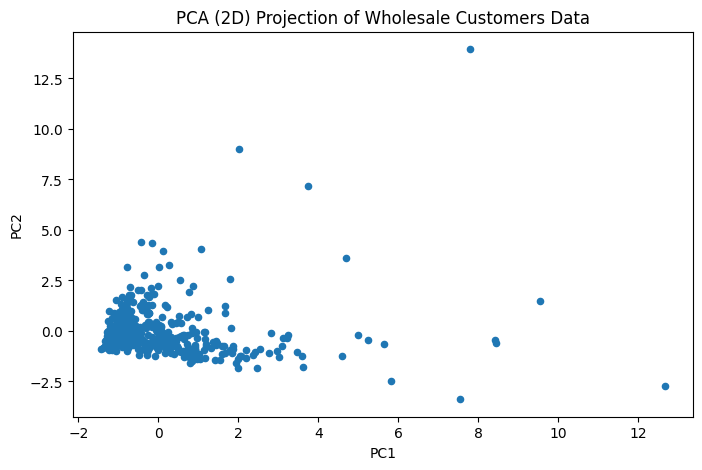

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20)
plt.title("PCA (2D) Projection of Wholesale Customers Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## DBSCAN Clustering
### Choosing eps & min_samples:
    - eps controls neighborhood radius.
    - min_samples is min points required for a core point.

In [9]:
dbscan = DBSCAN(eps=0.6, min_samples=5)
labels = dbscan.fit_predict(X)

np.unique(labels)

array([-1,  0,  1,  2])

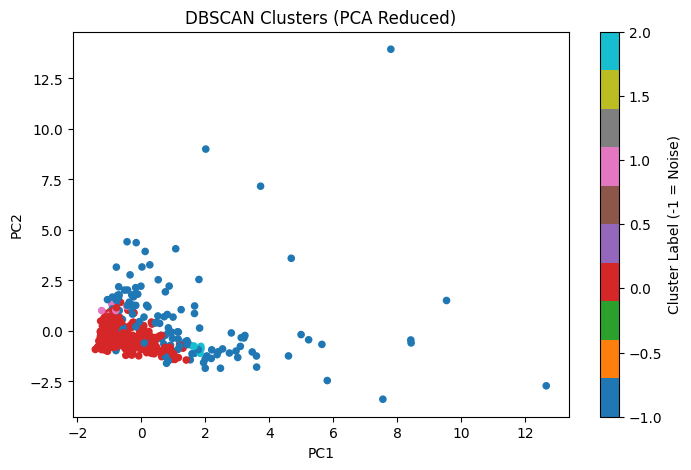

In [10]:
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=20)
plt.title("DBSCAN Clusters (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster Label (-1 = Noise)")
plt.show()

In [11]:
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
cluster_sizes

{np.int64(-1): np.int64(131),
 np.int64(0): np.int64(297),
 np.int64(1): np.int64(7),
 np.int64(2): np.int64(5)}